In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import re

import torch
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams

from prover.lean.verifier import Lean4ServerScheduler
from typing import List, Dict

In [2]:
!gpustat

rnn.ist.berkeley.edu  Tue Feb  4 12:54:29 2025  535.104.12
[0] NVIDIA RTX A6000 | 33'C,   0 % |   469 / 49140 MB |
[1] NVIDIA RTX A6000 | 32'C,   0 % |   466 / 49140 MB |
[2] NVIDIA RTX A6000 | 35'C,   0 % | 44244 / 49140 MB |
[3] NVIDIA RTX A6000 | 31'C,   0 % | 44218 / 49140 MB |
[4] NVIDIA RTX A6000 | 33'C,   0 % |   466 / 49140 MB |
[5] NVIDIA RTX A6000 | 32'C,   0 % |   466 / 49140 MB |
[6] NVIDIA RTX A6000 | 30'C,   0 % |   466 / 49140 MB |
[7] NVIDIA RTX A6000 | 33'C,   0 % |   567 / 49140 MB | ebronstein(28M)


In [3]:
#model_name = "deepseek-ai/DeepSeek-Prover-V1.5-RL"
model_name = "../../models/deepseek-prover-RL"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = LLM(model=model_name, max_num_batched_tokens=8192, seed=1, trust_remote_code=True, dtype="auto")

#lean4_scheduler = Lean4ServerScheduler(max_concurrent_requests=1, timeout=300, memory_limit=10, name='verifier')
lean4_scheduler = Lean4ServerScheduler(max_concurrent_requests=1, timeout=300, name='verifier')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 02-04 12:54:29 llm_engine.py:98] Initializing an LLM engine (v0.4.1) with config: model='../../models/deepseek-prover-RL', speculative_config=None, tokenizer='../../models/deepseek-prover-RL', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=1)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 02-04 12:54:29 utils.py:608] Found nccl from library /home/lukebailey/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 02-04 12:54:30 selector.py:77] Cannot use FlashAttention backend because the flash_attn package is not found. Please install it for better performance.
INFO 02-04 12:54:30 selector.py:33] Using XFormers backend.
INFO 02-04 12:54:33 model_runner.py:173] Loading model weights took 12.8725 GB
INFO 02-04 12:54:35 gpu_executor.py:119] # GPU blocks: 3858, # CPU blocks: 546
INFO 02-04 12:54:37 model_runner.py:976] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 02-04 12:54:37 model_runner.py:980] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory

In [4]:
# Setting up the problem
prompt = r'''Complete the following Lean 4 code:

```lean4
'''

code_prefix = r'''import Mathlib
import Aesop

set_option maxHeartbeats 0

open BigOperators Real Nat Topology Rat

/-- The second and fourth terms of a geometric sequence are $2$ and $6$. Which of the following is a possible first term?
Show that it is $\frac{2\sqrt{3}}{3}$.-/
theorem amc12b_2003_p6 (a r : ℝ) (u : ℕ → ℝ) (h₀ : ∀ k, u k = a * r ^ k) (h₁ : u 1 = 2)
  (h₂ : u 3 = 6) : u 0 = 2 / Real.sqrt 3 ∨ u 0 = -(2 / Real.sqrt 3) := by
'''

In [5]:
sampling_params = SamplingParams(
    temperature=1.0,
    max_tokens=2048,
    top_p=0.95,
    n=1,
)
model_inputs = [prompt + code_prefix]
model_outputs = model.generate(
    model_inputs,
    sampling_params,
    use_tqdm=True,
)
result = prompt + code_prefix + model_outputs[0].outputs[0].text
print(result)

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]

Complete the following Lean 4 code:

```lean4
import Mathlib
import Aesop

set_option maxHeartbeats 0

open BigOperators Real Nat Topology Rat

/-- The second and fourth terms of a geometric sequence are $2$ and $6$. Which of the following is a possible first term?
Show that it is $\frac{2\sqrt{3}}{3}$.-/
theorem amc12b_2003_p6 (a r : ℝ) (u : ℕ → ℝ) (h₀ : ∀ k, u k = a * r ^ k) (h₁ : u 1 = 2)
  (h₂ : u 3 = 6) : u 0 = 2 / Real.sqrt 3 ∨ u 0 = -(2 / Real.sqrt 3) := by
  simp_all only [Nat.one_eq_succ_zero, Nat.zero_eq, zero_add, Nat.succ_inj', one_mul]
  have h₃ : r ^ 2 = 3 := by nlinarith
  have h₄ : a = 2 / Real.sqrt 3 ∨ a = -(2 / Real.sqrt 3) := by
    apply or_iff_not_imp_right.2
    intro h
    field_simp [h, h₃] at h₁ h₂ ⊢
    nlinarith
  simp_all
```


In [6]:
hack_correct = prompt + code_prefix + '''  simp_all only [Nat.one_eq_succ_zero, Nat.zero_eq, zero_add, Nat.add_succ, Nat.add_zero,
    Nat.succ_add]
  have h₁' : a * r = 2 := by simpa [h₀] using h₁
  have h₂' : a * r ^ 3 = 6 := by simpa [h₀] using h₂
  have h₃ : r ^ 2 = 3 := by
    nlinarith
  have h₄ : a = 2 / Real.sqrt 3 ∨ a = -(2 / Real.sqrt 3) := by
    apply eq_or_eq_neg_of_sq_eq_sq <;>
    field_simp <;>
    nlinarith
  simpa [h₀] using h₄
```
'''

print(hack_correct)

Complete the following Lean 4 code:

```lean4
import Mathlib
import Aesop

set_option maxHeartbeats 0

open BigOperators Real Nat Topology Rat

/-- The second and fourth terms of a geometric sequence are $2$ and $6$. Which of the following is a possible first term?
Show that it is $\frac{2\sqrt{3}}{3}$.-/
theorem amc12b_2003_p6 (a r : ℝ) (u : ℕ → ℝ) (h₀ : ∀ k, u k = a * r ^ k) (h₁ : u 1 = 2)
  (h₂ : u 3 = 6) : u 0 = 2 / Real.sqrt 3 ∨ u 0 = -(2 / Real.sqrt 3) := by
  simp_all only [Nat.one_eq_succ_zero, Nat.zero_eq, zero_add, Nat.add_succ, Nat.add_zero,
    Nat.succ_add]
  have h₁' : a * r = 2 := by simpa [h₀] using h₁
  have h₂' : a * r ^ 3 = 6 := by simpa [h₀] using h₂
  have h₃ : r ^ 2 = 3 := by
    nlinarith
  have h₄ : a = 2 / Real.sqrt 3 ∨ a = -(2 / Real.sqrt 3) := by
    apply eq_or_eq_neg_of_sq_eq_sq <;>
    field_simp <;>
    nlinarith
  simpa [h₀] using h₄
```



In [8]:
# Check if this is correct
formatted_result = re.search(r'```lean4\n(.*?)\n```', hack_correct, re.DOTALL).group(1)
request_id_list = lean4_scheduler.submit_all_request([formatted_result])
outputs_list = lean4_scheduler.get_all_request_outputs(request_id_list)
print(outputs_list[0])
print(outputs_list[0]['complete'])

{'sorries': [], 'tactics': [], 'errors': [], 'warnings': [{'severity': 'warning', 'pos': {'line': 14, 'column': 7}, 'endPos': {'line': 14, 'column': 10}, 'data': "unused variable `h₁'`\nnote: this linter can be disabled with `set_option linter.unusedVariables false`"}, {'severity': 'warning', 'pos': {'line': 15, 'column': 7}, 'endPos': {'line': 15, 'column': 10}, 'data': "unused variable `h₂'`\nnote: this linter can be disabled with `set_option linter.unusedVariables false`"}, {'severity': 'warning', 'pos': {'line': 19, 'column': 35}, 'endPos': {'line': 19, 'column': 38}, 'data': 'Used `tac1 <;> tac2` where `(tac1; tac2)` would suffice\nnote: this linter can be disabled with `set_option linter.unnecessarySeqFocus false`'}, {'severity': 'warning', 'pos': {'line': 20, 'column': 15}, 'endPos': {'line': 20, 'column': 18}, 'data': 'Used `tac1 <;> tac2` where `(tac1; tac2)` would suffice\nnote: this linter can be disabled with `set_option linter.unnecessarySeqFocus false`'}], 'infos': [], 's

In [11]:
formatted_result = re.search(r'```lean4\n(.*?)\n```', hack_correct, re.DOTALL).group(1)
request_id_list = lean4_scheduler.submit_all_request([formatted_result])

In [12]:
request_id_list 

[3]

In [9]:
# Check if this is correct
formatted_result = re.search(r'```lean4\n(.*?)\n```', result, re.DOTALL).group(1)
request_id_list = lean4_scheduler.submit_all_request([formatted_result])
outputs_list = lean4_scheduler.get_all_request_outputs(request_id_list)
print(outputs_list[0])

{'sorries': [], 'tactics': [], 'errors': [{'severity': 'error', 'pos': {'line': 18, 'column': 4}, 'endPos': {'line': 18, 'column': 13}, 'data': 'linarith failed to find a contradiction\ncase h1.h\na r : ℝ\nu : ℕ → ℝ\nh₀ : ∀ (k : ℕ), u k = a * r ^ k\nh₂ : a * r ^ 3 = 6\nh₃ : r ^ 2 = 3\nh : ¬a = -(2 / √3)\nh₁ : a * r = 2\na✝ : a * √3 < 2\n⊢ False\nfailed'}], 'warnings': [], 'infos': [], 'system_messages': '', 'system_errors': None, 'ast': {}, 'verified_code': "import Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n/-- The second and fourth terms of a geometric sequence are $2$ and $6$. Which of the following is a possible first term?\nShow that it is $\\frac{2\\sqrt{3}}{3}$.-/\ntheorem amc12b_2003_p6 (a r : ℝ) (u : ℕ → ℝ) (h₀ : ∀ k, u k = a * r ^ k) (h₁ : u 1 = 2)\n  (h₂ : u 3 = 6) : u 0 = 2 / Real.sqrt 3 ∨ u 0 = -(2 / Real.sqrt 3) := by\n  simp_all only [Nat.one_eq_succ_zero, Nat.zero_eq, zero_add, Nat.succ_inj', one_mul]\n  have h₃ : r 

# Generating multiple proofs

In [10]:
proofs = []
# Generate 10 proofs
from tqdm import tqdm
for i in tqdm(range(10), desc="Generating proofs"):
    sampling_params = SamplingParams(
        temperature=1.0,
        max_tokens=2048,
        top_p=0.95,
        n=1,
    )
    model_inputs = [prompt + code_prefix]
    model_outputs = model.generate(
        model_inputs,
        sampling_params,
        use_tqdm=False,
    )
    result = prompt + code_prefix + model_outputs[0].outputs[0].text
    formatted_result = re.search(r'```lean4\n(.*?)\n```', result, re.DOTALL).group(1)
    proofs.append(formatted_result)

Generating proofs: 100%|██████████| 10/10 [00:34<00:00,  3.45s/it]


In [11]:
# Verify all proofs
correct = []

request_id_list = lean4_scheduler.submit_all_request(proofs)
outputs_list = lean4_scheduler.get_all_request_outputs(request_id_list)

In [16]:
print(outputs_list[0].keys())
print([x["pass"] for x in outputs_list])
print([x["complete"] for x in outputs_list])

dict_keys(['sorries', 'tactics', 'errors', 'warnings', 'infos', 'system_messages', 'system_errors', 'ast', 'verified_code', 'pass', 'complete', 'verify_time'])
[True, True, True, False, True, False, True, False, True, True]
[True, True, True, False, True, False, True, False, True, True]


In [17]:
lean4_scheduler.close()

All 1 LeanServerProcesses stopped


# Investigating returns from verifier

In [11]:
# load up ../results/verified_outputs.pkl
import pickle
with open('./results/verified_outputs_imo.pkl', 'rb') as f:
    verified_outputs = pickle.load(f)


In [19]:

for i in range(len(verified_outputs)):
    question = verified_outputs[i][0]

    for key, value in question.items():
        if key == "errors":
            print(key)
            print(len(value))
            print(value[0])
            print(value[0]["data"])
        else:
            print(key)
            print(value)
            print()

    print("\n==========\n")
    if i > 5:
        break


sorries
[]

tactics
[]

errors
3
{'severity': 'error', 'pos': {'line': 18, 'column': 38}, 'endPos': {'line': 18, 'column': 47}, 'data': 'unsolved goals\ncase hab.hab.hx\na b : ℤ\nh₀ : 0 < a ∧ 0 < b\nh₁ : ¬7 ∣ a\nh₂ : ¬7 ∣ b\nh₃ : ¬7 ∣ a + b\nthis : 0 < b\nh₄ : a + b < 19\nh₅ : a + b < 19\n⊢ 0 ≤ a + b\n\ncase hab.hcd.h\na b : ℤ\nh₀ : 0 < a ∧ 0 < b\nh₁ : ¬7 ∣ a\nh₂ : ¬7 ∣ b\nh₃ : ¬7 ∣ a + b\nthis : 0 < b\nh₄ : a + b < 19\nh₅ : a + b < 19\n⊢ 19 < a\n\ncase hcd.h\na b : ℤ\nh₀ : 0 < a ∧ 0 < b\nh₁ : ¬7 ∣ a\nh₂ : ¬7 ∣ b\nh₃ : ¬7 ∣ a + b\nthis : 0 < b\nh₄ : a + b < 19\nh₅ : a + b < 19\n⊢ 19 < b'}
unsolved goals
case hab.hab.hx
a b : ℤ
h₀ : 0 < a ∧ 0 < b
h₁ : ¬7 ∣ a
h₂ : ¬7 ∣ b
h₃ : ¬7 ∣ a + b
this : 0 < b
h₄ : a + b < 19
h₅ : a + b < 19
⊢ 0 ≤ a + b

case hab.hcd.h
a b : ℤ
h₀ : 0 < a ∧ 0 < b
h₁ : ¬7 ∣ a
h₂ : ¬7 ∣ b
h₃ : ¬7 ∣ a + b
this : 0 < b
h₄ : a + b < 19
h₅ : a + b < 19
⊢ 19 < a

case hcd.h
a b : ℤ
h₀ : 0 < a ∧ 0 < b
h₁ : ¬7 ∣ a
h₂ : ¬7 ∣ b
h₃ : ¬7 ∣ a + b
this : 0 < b
h₄ : a + b < 19
h₅ :

In [24]:
# load up ../results/verified_outputs.pkl
import pickle
with open('./results/verified_outputs.pkl', 'rb') as f:
    verified_outputs = pickle.load(f)


for i in range(len(verified_outputs)):
    question = verified_outputs[i][0]

    for key, value in question.items():
        if key == "errors":
            print(f"Number of errors: {len(value)}")
            for i, error in enumerate(value):
                print()
                print(f"Error {i}:")
                print(error["data"])
        else:
            print(key)
            print(value)
            print()

    print("\n==========\n")
    if i > 5:
        break

sorries
[]

tactics
[]

Number of errors: 1

Error 0:
unknown identifier 'h₀'
warnings
[]

infos
[]

system_messages


system_errors
None

ast
{}

verified_code
import Mathlib
import Aesop

set_option maxHeartbeats 0

open BigOperators Real Nat Topology Rat

/-- Expand the following expression: $7(3y+2)$ Show that it is 21y+14.-/
theorem mathd_algebra_182 (y : ℂ) : 7 * (3 * y + 2) = 21 * y + 14 := by
  apply Eq.symm
  have h₁ : ∀ n : ℕ, n ∣ Nat.sqrt 196 := h₀
  simpa [Nat.sqrt_eq_zero] using h₁ 0
  <;> simpa using h₁ 1
  <;> simpa using h₁ 2
  <;> simpa using h₁ 3
  <;> simpa using h₁ 4
  <;> simpa using h₁ 5
  <;> simpa using h₁ 6
  <;> simpa using h₁ 7
  <;> simpa using h₁ 8
  <;> simpa using h₁ 9
  <;> simpa using h₁ 10
  <;> simpa using h₁ 11
  <;> simpa using h₁ 12
  <;> simpa using h₁ 13
  <;> simpa using h₁ 14
  <;> simpa using h₁ 15
  <;> simpa using h₁ 16
  <;> simpa using h₁ 17
  <;> simpa using h₁ 18
  <;> simpa using h₁ 19
  <;> simpa using h₁ 20
  <;> simpa using h₁ 21
  <

In [264]:
from dataclasses import dataclass


import matplotlib.pyplot as plt
from collections import Counter

@dataclass
class LeanError:
    severity: str
    error_str: str
    error_type: str
    error_index: int
    code: str

def get_raw_error_data(verified_outputs, first_error=False):

    error_data = {}
    for i in range(len(verified_outputs)):
        if i not in error_data:
            error_data[i] = []

        attempts = verified_outputs[i]
        for j in range(len(attempts)):
            question = attempts[j]

            if question is None:
                error_data[i].append(
                    [
                        {
                            "severity" : "system",
                            "data" : "system error",
                            "verified_code" : ""
                        }
                    ]
                )
                continue

            if "errors" not in question:
                assert len(question["system_errors"]) >= 0 
                error_data[i].append(
                    [
                        {
                            "severity" : "system",
                            "data" : question["system_errors"],
                            "verified_code" : ""
                        }
                    ]
                )
            else:
                errors = question["errors"]
                for error in errors:
                    error["verified_code"] = question["verified_code"]

                if first_error:
                    error_data[i].append(errors[:1])
                else:
                    error_data[i].append(errors)
        

    return error_data

def categorize_lean_error(error_str: str) -> str:
    # Define error patterns and their corresponding categories
    error_patterns = {
        "failed to synthesize type class instance": "type_class_error",
        "type mismatch": "type_error",
        "unknown identifier": "unknown_identifier",
        "tactic": "tactic_error",
        "syntax error": "syntax_error",
        "timeout": "timeout",
        "out of memory": "memory_error",
        "no goals to be solved": "no_goal",
        "unsolved goals": "unsolved_goals",
        "simp made no progress" : "sime_made_no_progress",
        "simp_all made no progress" : "sime_all_made_no_progress",
        "omega" : "omega_error",
        "linarith failed to find a contradiction" : "linarith_failed_to_find_a_contradiction",
        "interval_cases" : "interval_cases_tactic_error",
        "maximum recursion depth has been reached" : "maximum_recursion_depth_has_been_reached",
        "unknown constant" : "unknown_constant",
        "invalid constructor" : "invalid_constructor",
        "missing cases" : "missing_cases",
        "invalid argument" : "invalid_argument",
        "unexpected token" : "syntax_error",
        "failed to synthesize" : "failed_to_synthesize",
        "invalid field" : "invalid_field",
    }

    error_patterns = {
        "failed to synthesize type class instance": "type_class_error",
        "type mismatch": "type_error",
        "unknown identifier": "out_of_scope",
        "tactic": "tactic_error",
        "syntax error": "syntax_error",
        "timeout": "timeout",
        "out of memory": "memory_error",
        "no goals to be solved": "tactic_error",
        "unsolved goals": "unsolved_goals",
        "simp made no progress" : "tactic_error",
        "simp_all made no progress" : "tactic_error",
        "omega" : "tactic_error",
        "linarith failed to find a contradiction" : "tactic_error",
        "interval_cases" : "tactic_error",
        "maximum recursion depth has been reached" : "recursion_error",
        "unknown constant" : "out_of_scope",
        "invalid constructor" : "invalid_argument",
        "missing cases" : "missing_cases",
        "invalid argument" : "invalid_argument",
        "unexpected token" : "syntax_error",
        "failed to synthesize" : "tactic_error",
        "invalid field" : "invalid_field",
    }
    
    # Check which patterns match
    matches = []
    for pattern, category in error_patterns.items():
        if pattern.lower() in error_str.lower():
            matches.append(category)
    
    # Handle multiple matches
    if len(matches) > 1:
        if "nested error" in error_str.lower():
            return matches[0]
        else:
            raise ValueError(f"Multiple error categories detected: {matches}")
    # Handle single match
    elif len(matches) == 1:
        return matches[0]
    # Handle no matches
    else:
        return "other"

def process_error_data(error_data):

    num_attempts = 0
    question_errors = []

    severity = set()
    error_info = []
    for i in range(len(error_data)):
        # We are in a specific question
        question_errors.append([])
        for j in range(len(error_data[i])):
            num_attempts += 1
            attempt_errors = error_data[i][j]
            question_errors[i].append(len(attempt_errors))

            for k in range(len(attempt_errors)):
                # This is the error data for question i, attempt j
                # If no error then this is an empty list
                error = error_data[i][j][k]
                severity.add(error["severity"])

                error_class = LeanError(
                    severity=error["severity"],
                    error_str=error["data"],
                    error_type=categorize_lean_error(error["data"]),
                    error_index=k,
                    code=error["verified_code"]
                )

                error_info.append(error_class)

    
    return num_attempts, question_errors, error_info, severity 

def plot_error_distribution(error_info):
    # Count the occurrences of each error type
    error_type_counts = Counter([error.error_type for error in error_info])

    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(error_type_counts.keys(), error_type_counts.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Lean Error Types')
    plt.xlabel('Error Type')
    plt.ylabel('Count')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()


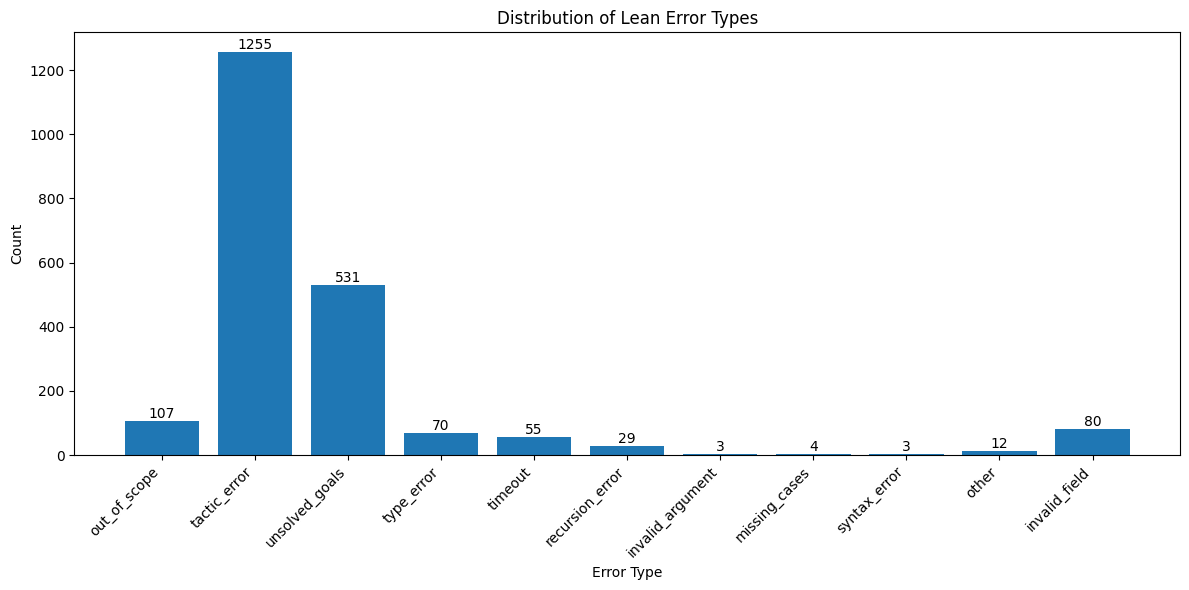

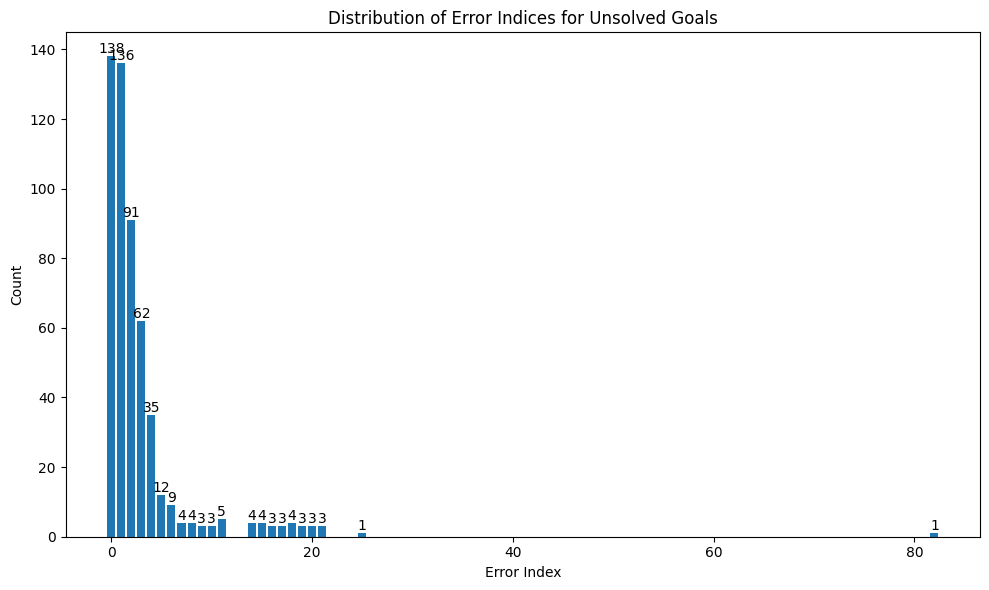

In [228]:
math_error_data = get_raw_error_data(verified_outputs)
num_attempts, question_errors, error_info, severity = process_error_data(math_error_data)
plot_error_distribution(error_info)

# Filter for unsolved_goals errors
unsolved_goals_errors = [error for error in error_info if error.error_type == "unsolved_goals"]
index_counts = Counter([error.error_index for error in unsolved_goals_errors])

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(index_counts.keys(), index_counts.values())
plt.title('Distribution of Error Indices for Unsolved Goals')
plt.xlabel('Error Index')
plt.ylabel('Count')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()



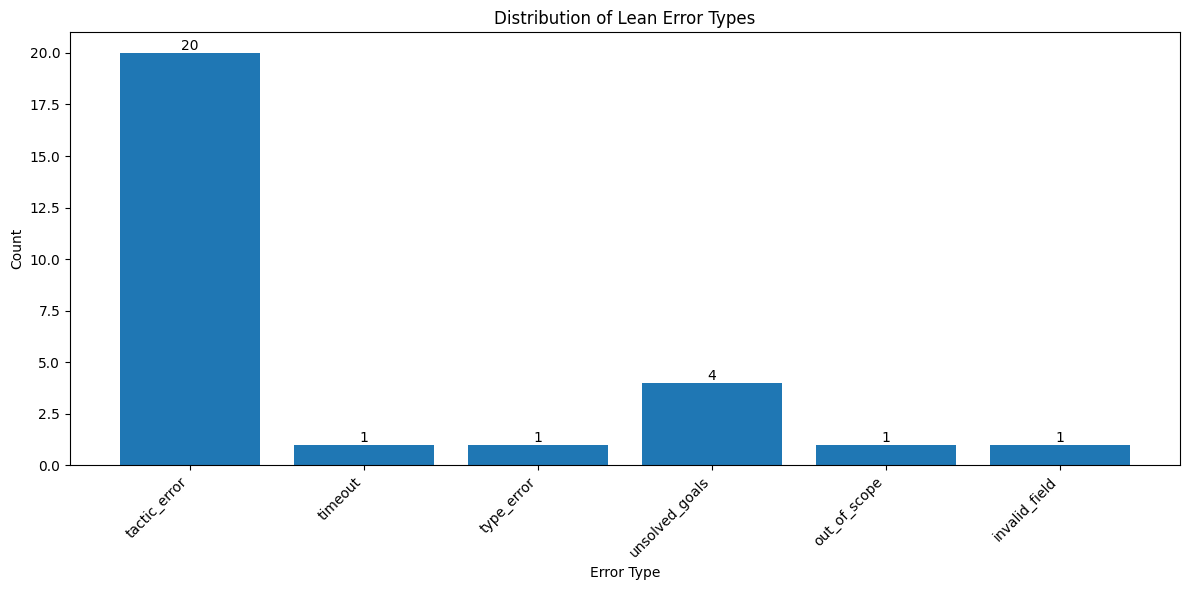

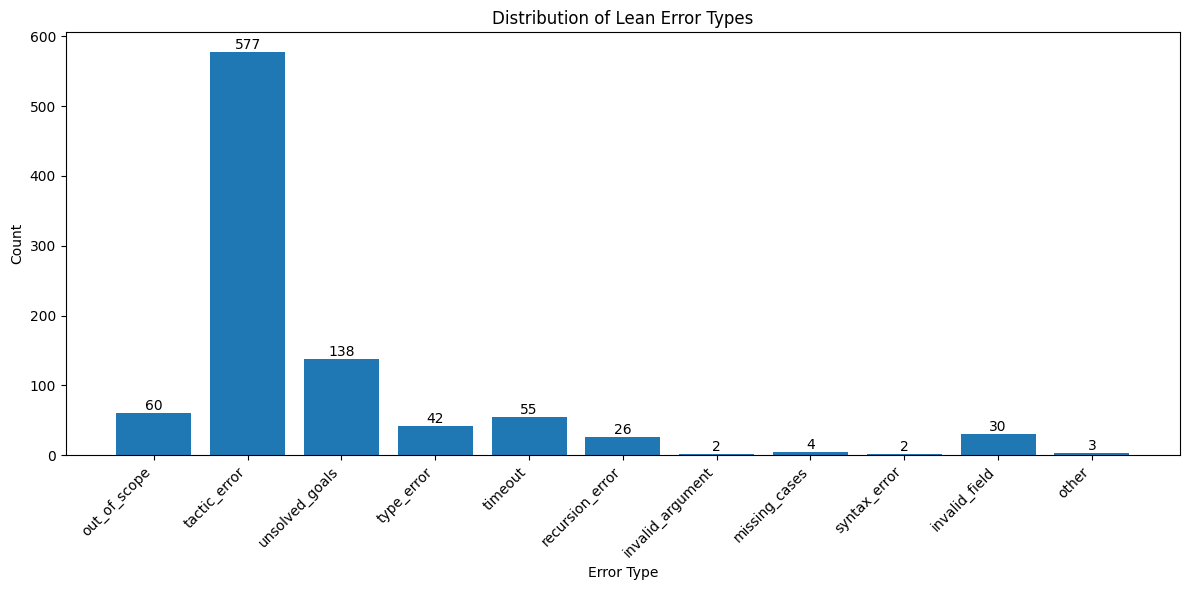

In [229]:
first_attempt_data = [[x[1]] for x in verified_outputs]
error_data: Dict[int, List[List[LeanError]]] = get_raw_error_data(first_attempt_data, first_error=True)
num_attempts, question_errors, error_info, severity = process_error_data(error_data)
plot_error_distribution(error_info)


error_data: Dict[int, List[List[LeanError]]] = get_raw_error_data(verified_outputs, first_error=True)
num_attempts, question_errors, error_info, severity = process_error_data(error_data)
plot_error_distribution(error_info)

In [261]:
import matplotlib.pyplot as plt
import numpy as np
import random

def create_stacked_bar_chart(error_counter, title):
    # Get all unique keys across all counters
    all_keys = set()
    for counter in error_counter:
        all_keys.update(counter.keys())
    all_keys = sorted(all_keys)
    
    # Create data matrix
    data = np.zeros((len(all_keys), len(error_counter)))
    for i, counter in enumerate(error_counter):
        for j, key in enumerate(all_keys):
            data[j, i] = counter.get(key, 0)
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(15, 6))
    bottom = np.zeros(len(error_counter))
    
    #colors = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226", "#1A8FE3"]
    colors = [
        "#4e79a7",  # Blue
        "#f28e2c",  # Orange
        "#e15759",  # Red
        "#76b7b2",  # Teal
        "#59a14f",  # Green
        "#edc949",  # Yellow
        "#af7aa1",  # Purple
        "#ff9da7",  # Pink
        "#9c755f",  # Brown
        "#bab0ab",  # Gray
        "#2e8b57",  # Sea Green
        "#1e90ff"   # Dodger Blue
    ]
    #random.shuffle(colors)
    
    bars = []
    for i, key in enumerate(all_keys):
        # Add hatching for unsolved_goals and tactic_error
        hatch_pattern = '//' if key in ['unsolved_goals', 'tactic_error'] else None
        bar = ax.bar(range(len(error_counter)), data[i], bottom=bottom,
                    label=key, color=colors[i], hatch=hatch_pattern)
        bottom += data[i]
        bars.append(bar)
    
    # Customize the plot
    ax.set_xlabel('Index')
    ax.set_ylabel('Count')
    ax.set_title(title)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Hide x ticks
    ax.set_xticks([])
    
    # Add legend

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    return


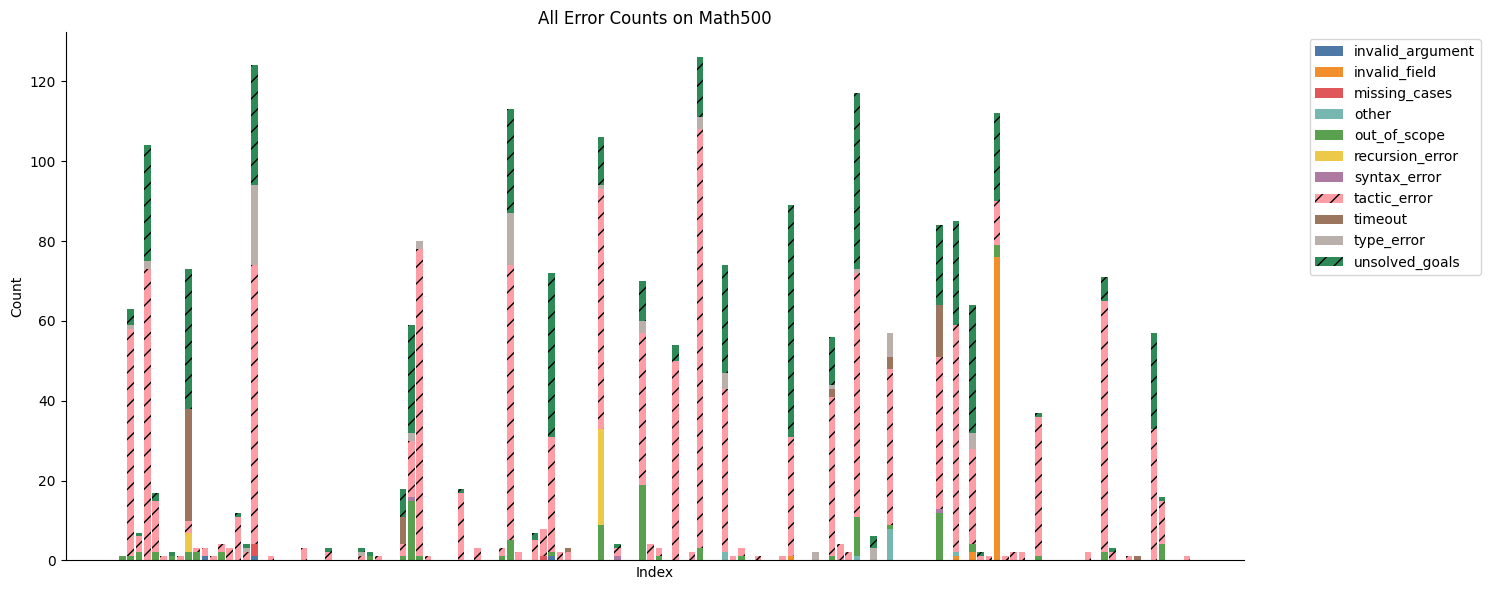

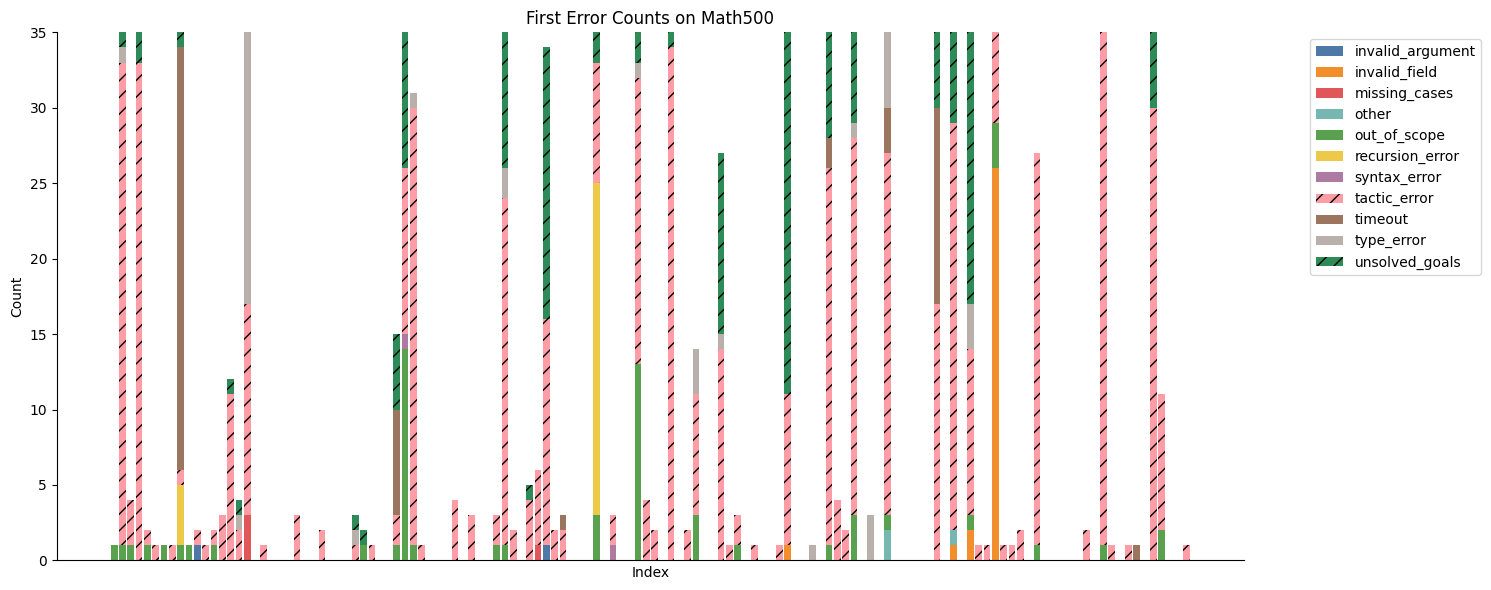

In [260]:
num_questions = len(verified_outputs)

error_counter = []
accuracy = []
for question_id in range(num_questions):
    question_data = [verified_outputs[question_id]]
    attempt_counts.append(len(question_data[0]))
    error_data = get_raw_error_data(question_data, first_error=False)
    num_attempts, question_errors, error_info, severity = process_error_data(error_data)

    question_errors: List[List[int]]
    question_errors = question_errors[0]
    assert num_attempts == len(question_errors)
    accuracy.append(1 - sum([1 for x in question_errors if x > 0]) / num_attempts)
    # Count up the number of each erro type
    error_type_counts = Counter([error.error_type for error in error_info])

    error_counter.append(error_type_counts)

create_stacked_bar_chart(error_counter, "All Error Counts on Math500")


error_counter = []
accuracy = []
for question_id in range(num_questions):
    question_data = [verified_outputs[question_id]]
    attempt_counts.append(len(question_data[0]))
    error_data = get_raw_error_data(question_data, first_error=True)
    num_attempts, question_errors, error_info, severity = process_error_data(error_data)

    question_errors: List[List[int]]
    question_errors = question_errors[0]
    assert num_attempts == len(question_errors)
    accuracy.append(1 - sum([1 for x in question_errors if x > 0]) / num_attempts)
    # Count up the number of each erro type
    error_type_counts = Counter([error.error_type for error in error_info])

    error_counter.append(error_type_counts)

create_stacked_bar_chart(error_counter, "First Error Counts on Math500")



In [262]:
# load up ../results/verified_outputs.pkl
import pickle
with open('./results/verified_outputs_imo.pkl', 'rb') as f:
    verified_outputs = pickle.load(f)


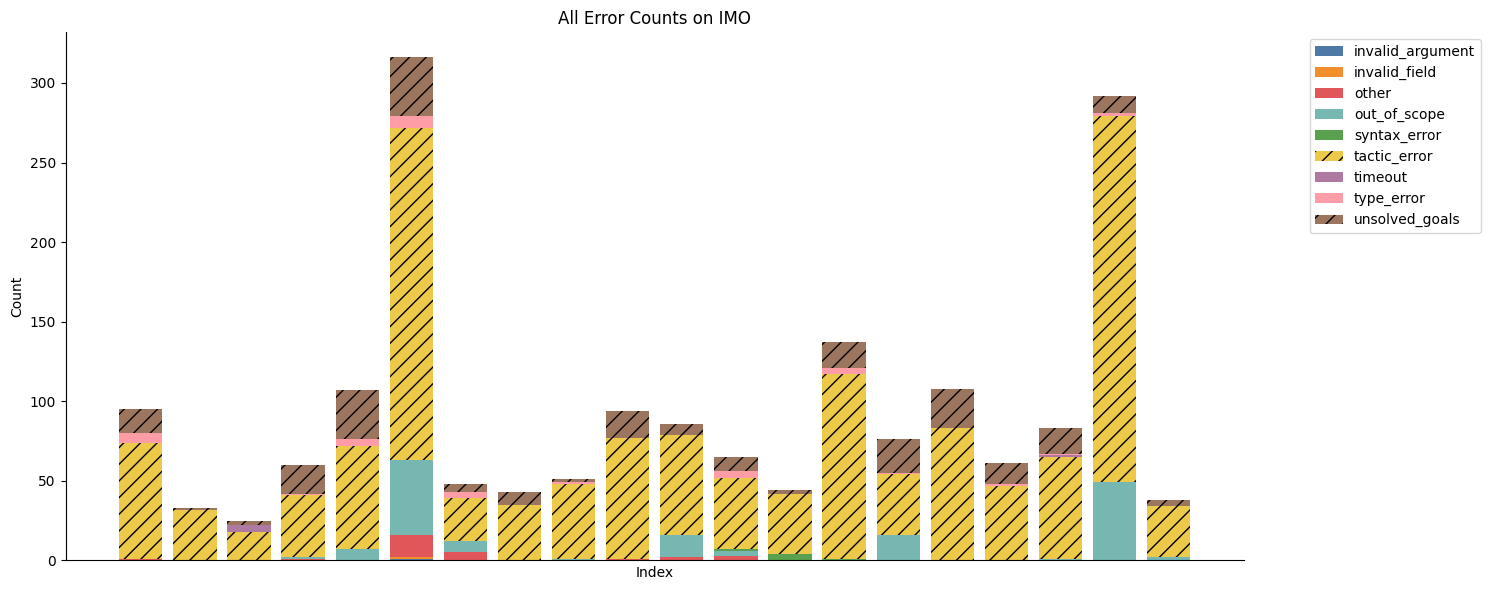

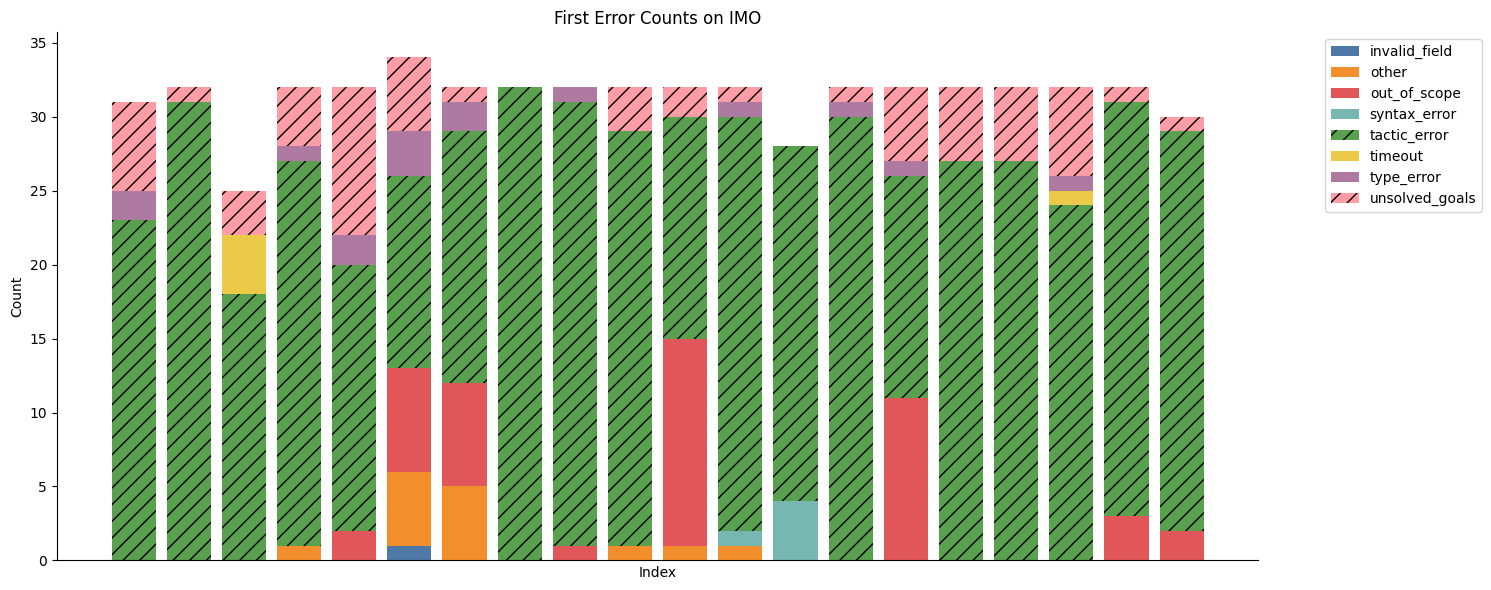

In [265]:
num_questions = len(verified_outputs)

error_counter = []
accuracy = []
for question_id in range(num_questions):
    question_data = [verified_outputs[question_id]]
    attempt_counts.append(len(question_data[0]))
    error_data = get_raw_error_data(question_data, first_error=False)
    num_attempts, question_errors, error_info, severity = process_error_data(error_data)

    question_errors: List[List[int]]
    question_errors = question_errors[0]
    assert num_attempts == len(question_errors)
    accuracy.append(1 - sum([1 for x in question_errors if x > 0]) / num_attempts)
    # Count up the number of each erro type
    error_type_counts = Counter([error.error_type for error in error_info])

    error_counter.append(error_type_counts)

create_stacked_bar_chart(error_counter, "All Error Counts on IMO")


error_counter = []
accuracy = []
for question_id in range(num_questions):
    question_data = [verified_outputs[question_id]]
    attempt_counts.append(len(question_data[0]))
    error_data = get_raw_error_data(question_data, first_error=True)
    num_attempts, question_errors, error_info, severity = process_error_data(error_data)

    question_errors: List[List[int]]
    question_errors = question_errors[0]
    assert num_attempts == len(question_errors)
    accuracy.append(1 - sum([1 for x in question_errors if x > 0]) / num_attempts)
    # Count up the number of each erro type
    error_type_counts = Counter([error.error_type for error in error_info])

    error_counter.append(error_type_counts)

create_stacked_bar_chart(error_counter, "First Error Counts on IMO")


# Testing out subprocess

In [4]:
import subprocess
import tempfile
import json
import os

In [5]:
HOME_DIR = os.path.expanduser('~')
DEFAULT_LAKE_PATH = f'{HOME_DIR}/.elan/bin/lake'
DEFAULT_LEAN_WORKSPACE = '../mathlib4/'

code = """import Mathlib
import Aesop
-- mul_assoc is a proof of (a * b) * c = a * (b * c)
-- rw [theorem a = b] replaces a in the goal with b
-- ← theorem a = b := theorem b = a
theorem calculating_test_3 (a b c d e f : ℝ) (h : a * b = c * d) (h' : e = f) : a * (b * e) = c * (d * f) := by
  rw [h']
  rw [← mul_assoc]
  rw [h]
  -- rw [mul_assoc]
"""

command = dict(cmd=code, allTactics=True, ast=True, tactics=True, premises=True)
message_str = json.dumps(command, ensure_ascii=False)

with tempfile.TemporaryFile(mode='w+', encoding='utf-8') as temp_file:
    temp_file.write(message_str + "\r\n\r\n")
    temp_file.seek(0)
    outputs = subprocess.run([DEFAULT_LAKE_PATH, "exe", 'repl'], stdin=temp_file, capture_output=True, text=True, cwd=DEFAULT_LEAN_WORKSPACE, timeout=300)
    result = json.loads(outputs.stdout)

print(result)

{'tactics': [{'tactic': "rw [h']", 'proofState': 0, 'pos': {'line': 7, 'column': 2}, 'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ a * (b * e) = c * (d * f)", 'endPos': {'line': 7, 'column': 9}}, {'tactic': 'rw [← mul_assoc]', 'proofState': 1, 'pos': {'line': 8, 'column': 2}, 'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ a * (b * f) = c * (d * f)", 'endPos': {'line': 8, 'column': 18}}, {'tactic': 'rw [h]\n  -- rw [mul_assoc]', 'proofState': 2, 'pos': {'line': 9, 'column': 2}, 'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ a * b * f = c * (d * f)", 'endPos': {'line': 9, 'column': 8}}], 'messages': [{'severity': 'error', 'pos': {'line': 6, 'column': 109}, 'endPos': {'line': 9, 'column': 8}, 'data': "unsolved goals\na b c d e f : ℝ\nh : a * b = c * d\nh' : e = f\n⊢ c * d * f = c * (d * f)"}], 'env': 0, 'ast': {'tactics': [{'stateBefore': "a b c d e f : ℝ\nh : a * b = c * d\nh' : e = f\n⊢ a * (b * e) = c * (d * f)", 'stateAfter': "a b c d e f : ℝ\nh : a * b 

In [10]:
print(result["messages"][0]["data"])

unsolved goals
a b c d e f : ℝ
h : a * b = c * d
h' : e = f
⊢ c * d * f = c * (d * f)


In [32]:
for tactic in result["ast"]["tactics"]:
    print(tactic["stateBefore"])
    print(tactic["stateAfter"])
    print()

a b c d e f : ℝ
h : a * b = c * d
h' : e = f
⊢ a * (b * e) = c * (d * f)
a b c d e f : ℝ
h : a * b = c * d
h' : e = f
⊢ a * (b * f) = c * (d * f)

a b c d e f : ℝ
h : a * b = c * d
h' : e = f
⊢ a * (b * e) = c * (d * f)
a b c d e f : ℝ
h : a * b = c * d
h' : e = f
⊢ a * (b * f) = c * (d * f)

a b c d e f : ℝ
h : a * b = c * d
h' : e = f
⊢ a * (b * f) = c * (d * f)
a b c d e f : ℝ
h : a * b = c * d
h' : e = f
h_test : a * b = c * d
⊢ a * (b * f) = c * (d * f)

a b c d e f : ℝ
h : a * b = c * d
h' : e = f
⊢ a * b = c * d
no goals

a b c d e f : ℝ
h : a * b = c * d
h' : e = f
h_test : a * b = c * d
⊢ a * (b * f) = c * (d * f)
a b c d e f : ℝ
h : a * b = c * d
h' : e = f
h_test : a * b = c * d
⊢ a * b * f = c * (d * f)

a b c d e f : ℝ
h : a * b = c * d
h' : e = f
h_test : a * b = c * d
⊢ a * (b * f) = c * (d * f)
a b c d e f : ℝ
h : a * b = c * d
h' : e = f
h_test : a * b = c * d
⊢ a * b * f = c * (d * f)

a b c d e f : ℝ
h : a * b = c * d
h' : e = f
h_test : a * b = c * d
⊢ a * b * f = c

In [17]:
result["tactics"]

[{'tactic': "rw [h']",
  'proofState': 0,
  'pos': {'line': 7, 'column': 2},
  'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ a * (b * e) = c * (d * f)",
  'endPos': {'line': 7, 'column': 9}},
 {'tactic': 'rw [← mul_assoc]',
  'proofState': 1,
  'pos': {'line': 8, 'column': 2},
  'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ a * (b * f) = c * (d * f)",
  'endPos': {'line': 8, 'column': 18}},
 {'tactic': 'rw [h]',
  'proofState': 2,
  'pos': {'line': 9, 'column': 2},
  'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ a * b * f = c * (d * f)",
  'endPos': {'line': 9, 'column': 8}},
 {'tactic': 'rw [mul_assoc]',
  'proofState': 3,
  'pos': {'line': 10, 'column': 2},
  'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ c * d * f = c * (d * f)",
  'endPos': {'line': 10, 'column': 16}}]

# Testing out deepseek oracle

In [35]:
!gpustat

rnn.ist.berkeley.edu  Mon Feb  3 22:23:40 2025  535.104.12
[0] NVIDIA RTX A6000 | 28'C,   0 % |  1790 / 49140 MB | karimabdel(1318M)
[1] NVIDIA RTX A6000 | 32'C,   0 % |   469 / 49140 MB |
[2] NVIDIA RTX A6000 | 32'C,   0 % |   469 / 49140 MB |
[3] NVIDIA RTX A6000 | 31'C,   0 % | 44218 / 49140 MB |
[4] NVIDIA RTX A6000 | 32'C,   0 % |   469 / 49140 MB |
[5] NVIDIA RTX A6000 | 32'C,   0 % |   469 / 49140 MB |
[6] NVIDIA RTX A6000 | 30'C,   0 % |   469 / 49140 MB |
[7] NVIDIA RTX A6000 | 32'C,   0 % |   567 / 49140 MB | ebronstein(28M)


In [38]:
#model_name = "deepseek-ai/DeepSeek-Prover-V1.5-RL"
model_name = "../../models/deepseek-prover-RL"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = LLM(model=model_name, max_num_batched_tokens=8192, seed=1, trust_remote_code=True, dtype="auto")

#lean4_scheduler = Lean4ServerScheduler(max_concurrent_requests=1, timeout=300, memory_limit=10, name='verifier')
lean4_scheduler = Lean4ServerScheduler(max_concurrent_requests=1, timeout=300, name='verifier')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 02-03 22:23:57 llm_engine.py:98] Initializing an LLM engine (v0.4.1) with config: model='../../models/deepseek-prover-RL', speculative_config=None, tokenizer='../../models/deepseek-prover-RL', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=1)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 02-03 22:23:57 utils.py:608] Found nccl from library /home/lukebailey/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 02-03 22:23:58 selector.py:77] Cannot use FlashAttention backend because the flash_attn package is not found. Please install it for better performance.
INFO 02-03 22:23:58 selector.py:33] Using XFormers backend.
INFO 02-03 22:24:11 model_runner.py:173] Loading model weights took 12.8725 GB
INFO 02-03 22:24:13 gpu_executor.py:119] # GPU blocks: 3858, # CPU blocks: 546
INFO 02-03 22:24:15 model_runner.py:976] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 02-03 22:24:15 model_runner.py:980] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory

In [67]:
# Setting up the problem
prompt = r'''Complete the following Lean 4 code:

```lean4
'''

code_prefix = r'''import Mathlib
import Aesop

/- Show that a * (b * e) = c * (d * f) given that a * b = c * d and e = f. -/
theorem calculating_test_3 (a b c d e f : ℝ) (h : a * b = c * d) (h' : e = f) : a * (b * e) = c * (d * f) := by
  rw [h']
  rw [← mul_assoc]
'''

In [68]:
sampling_params = SamplingParams(
    temperature=1.0,
    max_tokens=2048,
    top_p=0.95,
    n=1,
)
model_inputs = [prompt + code_prefix]
model_outputs = model.generate(
    model_inputs,
    sampling_params,
    use_tqdm=True,
)
result = prompt + code_prefix + model_outputs[0].outputs[0].text
print(result)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

Complete the following Lean 4 code:

```lean4
import Mathlib
import Aesop

/- Show that a * (b * e) = c * (d * f) given that a * b = c * d and e = f. -/
theorem calculating_test_3 (a b c d e f : ℝ) (h : a * b = c * d) (h' : e = f) : a * (b * e) = c * (d * f) := by
  rw [h']
  rw [← mul_assoc]
  rw [h]
  ring
```


In [69]:
formatted_result = re.search(r'```lean4\n(.*?)\n```', result, re.DOTALL).group(1)
print(formatted_result)

import Mathlib
import Aesop

/- Show that a * (b * e) = c * (d * f) given that a * b = c * d and e = f. -/
theorem calculating_test_3 (a b c d e f : ℝ) (h : a * b = c * d) (h' : e = f) : a * (b * e) = c * (d * f) := by
  rw [h']
  rw [← mul_assoc]
  rw [h]
  ring


In [70]:
HOME_DIR = os.path.expanduser('~')
DEFAULT_LAKE_PATH = f'{HOME_DIR}/.elan/bin/lake'
DEFAULT_LEAN_WORKSPACE = '../mathlib4/'

code = formatted_result

command = dict(cmd=code, allTactics=True, ast=True, tactics=True, premises=True)
message_str = json.dumps(command, ensure_ascii=False)

with tempfile.TemporaryFile(mode='w+', encoding='utf-8') as temp_file:
    temp_file.write(message_str + "\r\n\r\n")
    temp_file.seek(0)
    outputs = subprocess.run([DEFAULT_LAKE_PATH, "exe", 'repl'], stdin=temp_file, capture_output=True, text=True, cwd=DEFAULT_LEAN_WORKSPACE, timeout=300)
    result = json.loads(outputs.stdout)

print(result)

{'tactics': [{'tactic': "rw [h']", 'proofState': 0, 'pos': {'line': 6, 'column': 2}, 'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ a * (b * e) = c * (d * f)", 'endPos': {'line': 6, 'column': 9}}, {'tactic': 'rw [← mul_assoc]', 'proofState': 1, 'pos': {'line': 7, 'column': 2}, 'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ a * (b * f) = c * (d * f)", 'endPos': {'line': 7, 'column': 18}}, {'tactic': 'rw [h]', 'proofState': 2, 'pos': {'line': 8, 'column': 2}, 'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ a * b * f = c * (d * f)", 'endPos': {'line': 8, 'column': 8}}, {'tactic': 'ring', 'proofState': 3, 'pos': {'line': 9, 'column': 2}, 'goals': "a b c d e f : ℝ h : a * b = c * d h' : e = f ⊢ c * d * f = c * (d * f)", 'endPos': {'line': 9, 'column': 6}}], 'env': 0, 'ast': {'tactics': [{'stateBefore': "a b c d e f : ℝ\nh : a * b = c * d\nh' : e = f\n⊢ a * (b * e) = c * (d * f)", 'stateAfter': "a b c d e f : ℝ\nh : a * b = c * d\nh' : e = f\n⊢ a * (b * f) = c * 

In [71]:
result["messages"]

KeyError: 'messages'

In [72]:
len(result["tactics"])


4

### Ring Example

In [75]:
# Setting up the problem
prompt = r'''Complete the following Lean 4 code:

```lean4
'''

code_prefix = r'''import Mathlib
import Aesop

variable (R : Type*) [CommRing R]

theorem mul_zero (a : R) : a * 0 = 0 := by
  have h : a * 0 + a * 0 = a * 0 + 0 := by
    rw [← mul_add, add_zero, add_zero]
'''
#  have h : a * 0 + a * 0 = a * 0 + 0 := by
#    rw [← mul_add, add_zero, add_zero]
#  rw [add_left_cancel h]

sampling_params = SamplingParams(
    temperature=1.0,
    max_tokens=2048,
    top_p=0.95,
    n=1,
)
model_inputs = [prompt + code_prefix]
model_outputs = model.generate(
    model_inputs,
    sampling_params,
    use_tqdm=True,
)
result = prompt + code_prefix + model_outputs[0].outputs[0].text
formatted_result = re.search(r'```lean4\n(.*?)\n```', result, re.DOTALL).group(1)
print(formatted_result)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

import Mathlib
import Aesop

variable (R : Type*) [CommRing R]

theorem mul_zero (a : R) : a * 0 = 0 := by
  have h : a * 0 + a * 0 = a * 0 + 0 := by
    rw [← mul_add, add_zero, add_zero]
  simpa using h
